In [39]:
import math
from graphviz import Digraph

In [40]:
class Value:
    def __init__(self, data, _prev=(), _op="", label=""):
        self.data = data
        self._prev = set(_prev)
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.grad * out.data

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), (
            "only supporting int/float powers for now"
        )
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += out.grad * other * (self.data ** (other - 1))

        out._backward = _backward
        return out

    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += out.grad * (1 - t**2)

        out._backward = _backward
        return out

    def relu(self):
        out = Value(max(0, self.data), (self,), "ReLU")

        def _backward():
            self.grad += out.grad * float(out.data > 0)

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def _build_topo(v):
            if v not in visited:
                visited.add(v)
                for node in v._prev:
                    _build_topo(node)
                topo.append(v)

        _build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __repr__(self):
        return f"Value(data = {self.data})"


In [41]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [42]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"

x2w2 = x2 * w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = "n"

o = n.relu()
# o = n.tanh()
o.label = "o"

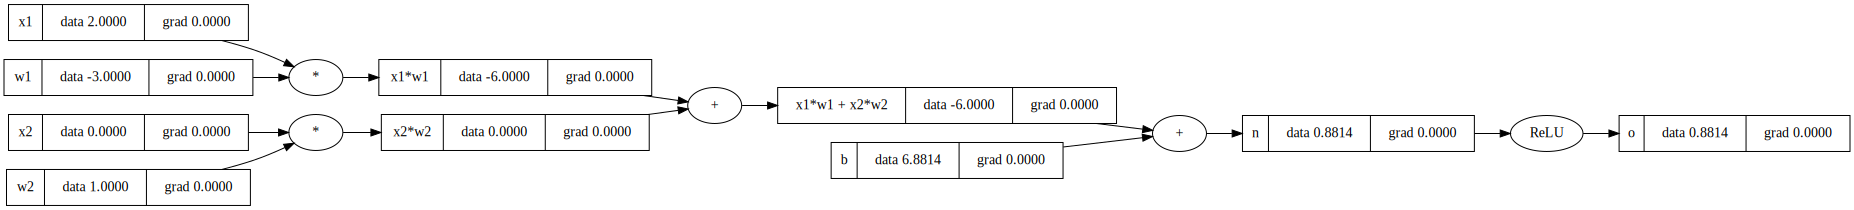

In [43]:
draw_dot(o)

In [44]:
o.backward()

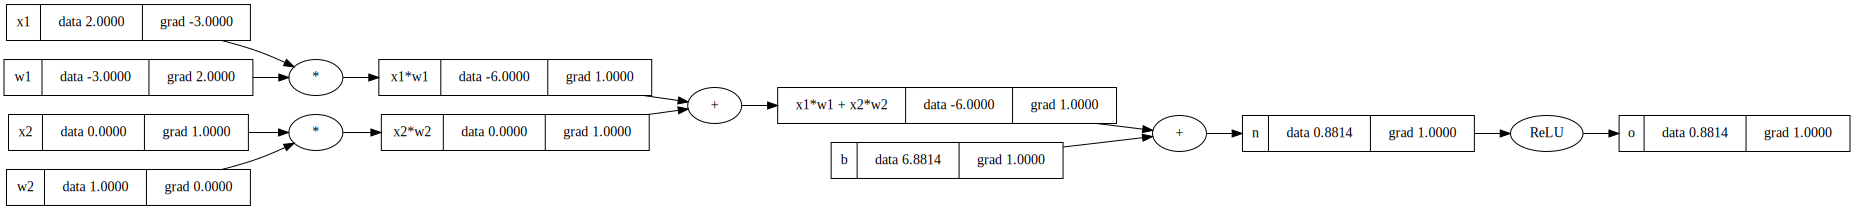

In [45]:
draw_dot(o)

In [46]:
a = Value(2.0, label="a")
b = Value(3.0, label="b")

e = a + b
e.label = "e"

d = a * b
d.label = "d"

f = d * e
f.label = "f"

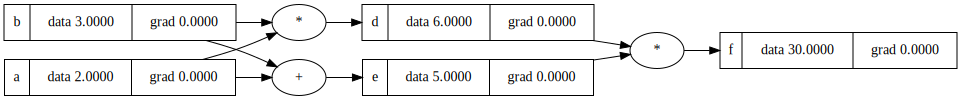

In [47]:
draw_dot(f)

In [48]:
f.backward()

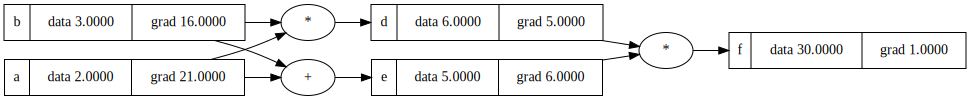

In [49]:
draw_dot(f)

In [50]:
w = Value(10.0)

2 * w

Value(data = 20.0)

In [51]:
import random

In [52]:
class Module:
    def zero_grad(self):
        for param in self.parameters():
            param.grad = 0
    
    def parameters(self):
        return []

In [53]:
class Neuron:
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum([xi * wi for xi, wi in zip(x, self.w)], start=self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'} Neuron({len(self.w)})"

In [54]:
class Layer:
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [param for n in self.neurons for param in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [55]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [
            Layer(sz[i], sz[i + 1], nonlin=i != len(nouts) - 1)
            for i in range(len(nouts))
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            return x

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [56]:
a = Value(2.0)
2*a

Value(data = 4.0)

In [57]:
a*2

Value(data = 4.0)

In [58]:
1 + a

Value(data = 3.0)

In [59]:
a + 1

Value(data = 3.0)